### Notebook Goals
* Capturar mensagens da rede social Twitter, para avaliar sentimentos sobre um produto.
* Neste caso será considerado o produto 'livros'.
* Para esse cálculo será utilizado inteligência artifical com NLP.

#### NLP
* NLP (Natural Linguage Processing) explora habilidades computacionais para entender e classificar textos.

##### Data Prep

In [1]:
import tweepy
import pandas as pd

In [2]:
#Import text file keys 
txtKeys = open('ktw.txt', 'r').read().splitlines()
api_key = txtKeys[0]
api_key_secret = txtKeys[1]
api_token = txtKeys[2]
api_token_secret = txtKeys[3]

In [3]:
#Twitter API authentication 
auth = tweepy.OAuthHandler(consumer_key=api_key, consumer_secret=api_key_secret)
auth.set_access_token(api_token, api_token_secret)
api = tweepy.API(auth)

In [4]:
#API params
search_query = 'livro' + ' -filter:retweets'
tweet_amount = 2000
tweets = tweepy.Cursor(api.search, q=search_query, lang='pt', wait_on_rate_limit=True
                      ).items(tweet_amount)

In [5]:
#Tweets list
cols = set()
allowed_types = [str, int]
tw_data = []

for tw in tweets:
    tw_dict = dict(vars(tw))
    tw_keys = tw_dict.keys()
    filter_data = {}
    for k in tw_keys:
        try:
            k_type = type(tw_dict[k])
        except:
            k_type = None
        if k_type != None:
            if k_type in allowed_types:
                cols.add(k)
                filter_data[k] = tw_dict[k]
    tw_data.append(filter_data)

header_cols = list(cols)
#tw_data

In [6]:
#Tweets Dataframe
df = pd.DataFrame(tw_data, columns=header_cols)
#df.head()
df.columns

Index(['favorite_count', 'source', 'in_reply_to_screen_name',
       'quoted_status_id', 'text', 'in_reply_to_user_id',
       'in_reply_to_status_id_str', 'id', 'source_url', 'retweet_count',
       'in_reply_to_status_id', 'in_reply_to_user_id_str', 'id_str', 'lang',
       'quoted_status_id_str'],
      dtype='object')

In [7]:
#Cleaning Data
df.drop(['in_reply_to_screen_name', 'source_url', 'in_reply_to_user_id_str', 'in_reply_to_status_id_str', 'favorite_count', 'quoted_status_id_str', 'lang', 'in_reply_to_user_id', 'quoted_status_id',
         'id_str', 'source', 'in_reply_to_status_id']
        , inplace=True
        , axis=1)

In [8]:
df = df[['id', 'text', 'retweet_count']]

In [9]:
#Sample by retweets count
df.sort_values('retweet_count', ascending=False).head()

,id,text,retweet_count
987,1401253652480892931,larissa manoela booktt SARAH TE AMAMOS YIXING ...,28
914,1401254485696073734,"""COMO A ANSIEDADE PODE AMEAÇAR SEU RELACIONAME...",26
127,1401263396566319114,joão pessoa maquiagem açaí caraio maconha UFSC...,16
1802,1401245298815647746,@votebybelieber Abc joão pessoa maquiagem açaí...,15
838,1401255184634978311,larissa manoela booktt SARAH TE AMAMOS YIXING ...,13


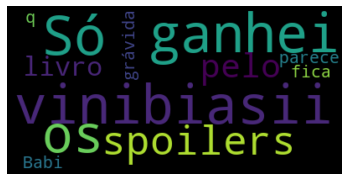

In [10]:
#Wordcloud by retweets count
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

wordcloud = WordCloud().generate(df.text[3])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### NLP

In [11]:
import re #Regulary Expretions
import nltk #Natural Linguage Toolkit
from nltk import tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords

In [12]:
#Regulary Expretions
def remove_re(expressions):
    tweets_cl = []
    for exp in expressions:
        f_expre = re.sub('@\S+', '', exp)
        s_expre = re.sub('https\S+', '', f_expre)
        final_expre = s_expre.lower().replace('.', '').replace(',', '').replace('-','').replace('\n', '').replace(')','').replace('(','').replace('#', '').replace('!', '').replace('?', '').replace(';', '').replace('[', '').replace(']', '').replace('00', '').replace('03', '').replace('livro', '')
        tweets_cl.append(final_expre)
    return(tweets_cl)

df_list = list(df.text)
tweets_cl = remove_re(df_list)
#tweets_cl

In [13]:
#Tokenize
word_tokens = []
for tk in tweets_cl:
    #print(word_tokenize(tk, language='portuguese'))
    word_tokens.append(word_tokenize(tk, language='portuguese'))

In [14]:
#Stopwords
stopwords = set(nltk.corpus.stopwords.words('portuguese'))
token_filter = []
for wt in word_tokens:
    for wtk in wt:
        if wtk not in stopwords:
            token_filter.append(wtk)

In [15]:
#Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(analyzer='word',ngram_range=(1, 2), max_df=1.0, min_df=1, max_features=None)
count_train = vect.fit(token_filter)
bag_of_words  = vect.transform(token_filter)

In [16]:
#Idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
txt_fitted = tf.fit(token_filter)
txt_transformed = txt_fitted.transform(token_filter)
#print(txt_transformed)

In [17]:
#Classification
idf = tf.idf_
idfDict = dict(zip(txt_fitted.get_feature_names(), idf))
token_weight = pd.DataFrame.from_dict(idfDict, orient='index').reset_index()
token_weight.columns=('token','weight')


<AxesSubplot:xlabel='weight', ylabel='token'>

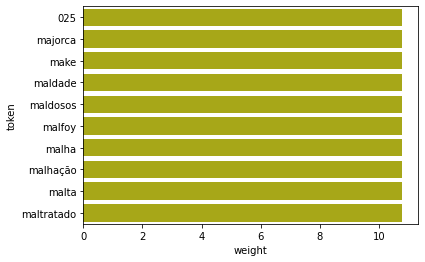

In [18]:
import seaborn as sns

#Largest
largest = token_weight.sort_values('weight', ascending=False).nlargest(10, 'weight')
sns.barplot(x="weight", y="token", data=largest,
            label="Palavras chaves primárias", color='y')

<AxesSubplot:xlabel='weight', ylabel='token'>

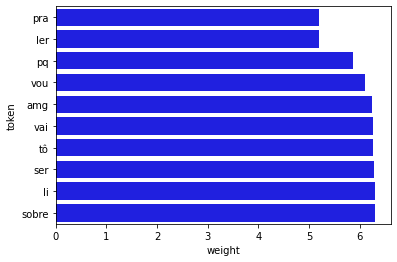

In [19]:
#Smallest
smallest = token_weight.sort_values('weight', ascending=False).nsmallest(10, 'weight')
sns.barplot(x="weight", y="token", data=smallest,
            label="Palavras chaves secundárias", color='b')
